# Maps of change in speed. 

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46839,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:36089,Total threads: 4
Dashboard: /proxy/43259/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:35837,


Define experiments and cookbook sessions. 

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
expt_qian = '01deg_jra55v13_ryf9091_qian_wthp'
expt_qian_m = '01deg_jra55v13_ryf9091_qian_wthmp'

# database for perturbations
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

Define analysis and plotting functions. 

In [4]:
def read_data(start_time, end_time, expt, session):
    print(f"Reading velocities from:{expt}")
    lat_slice  = slice(-80,-59)
    z_slice = slice(0,500)
    
    uvel = cc.querying.getvar(expt, 'u', session, frequency='1 monthly', start_time=start_time, end_time=end_time)
    vvel = cc.querying.getvar(expt, 'v', session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
    dzt = cc.querying.getvar(expt, 'dzt',session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
    uvel = uvel.sel(yu_ocean=lat_slice).sel(st_ocean=z_slice)
    vvel = vvel.sel(yu_ocean=lat_slice).sel(st_ocean=z_slice)
    dzt = dzt.sel(yt_ocean=lat_slice).sel(st_ocean=z_slice)

    # reassign dzt coordinates for multiplication
    dzt = dzt.assign_coords({"xt_ocean" : uvel.xu_ocean.data}).rename(xt_ocean="xu_ocean")
    dzt = dzt.assign_coords({"yt_ocean" : uvel.isel(yu_ocean=slice(None, -1)).yu_ocean.data}).rename(yt_ocean="yu_ocean")

    # calculate speed
    spd = np.sqrt(uvel**2 + vvel**2)
    spd_ave = (spd.isel(yu_ocean=slice(None, -1))*(dzt/dzt.sum(dim='st_ocean'))).sum(dim='st_ocean')
    spd_ave = spd_ave.mean(dim='time').load()
    
    return spd_ave

# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

def add_circle_axes(fig, axes_pos):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    return ax

def plot_anom(ax, ds_pert, ds_con, title, scale_max, cmap):
    fontsize=14
    norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
    cb = ax.pcolormesh(ds_con.xu_ocean, ds_con.yu_ocean, ds_pert-ds_con, 
                       norm=norm, cmap=cmap, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax.text(90,-88,title, ha='center', va='center', fontsize = 14, c='w',fontweight = 'bold',transform=ccrs.PlateCarree())
    
    return cb

def colorbar_vert(cb, axes, label):
    fontsize=14
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

### Upper ocean (0-500 m speed)

Read in speed from control simulation. 

In [6]:
%%time
spd_cntl = read_data('2160-01-01', '2164-12-31', control, master_session)

Reading velocities from:01deg_jra55v13_ryf9091
CPU times: user 2min 1s, sys: 9.4 s, total: 2min 10s
Wall time: 3min 6s


Read in speed from experiments. 

In [5]:
spd_ssp245 = read_data('2160-01-01', '2164-12-31', ssp245, expt_session)
spd_ssp245mw = read_data('2160-01-01', '2164-12-31', ssp245mw, expt_session)
spd_ssp585 = read_data('2160-01-01', '2164-12-31', ssp585, expt_session)
spd_ssp585mw = read_data('2160-01-01', '2164-12-31', ssp585mw, expt_session)

Save to file.

In [8]:
spd_cntl = spd_cntl.rename('speed')
spd_cntl.attrs['Name'] = '0-500m depth-averaged speed'
spd_cntl.attrs['Units'] = 'm/s'
spd_cntl.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_cntl.attrs['Experiment'] = 'Control (RYF)'
spd_cntl.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_control.nc')

spd_ssp245 = spd_ssp245.rename('speed')
spd_ssp245.attrs['Name'] = '0-500m depth-averaged speed'
spd_ssp245.attrs['Units'] = 'm/s'
spd_ssp245.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp245.attrs['Experiment'] = 'SSP245'
spd_ssp245.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_ssp245.nc')

spd_ssp245mw = spd_ssp245mw.rename('speed')
spd_ssp245mw.attrs['Name'] = '0-500m depth-averaged speed'
spd_ssp245mw.attrs['Units'] = 'm/s'
spd_ssp245mw.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp245mw.attrs['Experiment'] = 'SSP245 with Meltwater'
spd_ssp245mw.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_ssp245mw.nc')

spd_ssp585 = spd_ssp585.rename('speed')
spd_ssp585.attrs['Name'] = '0-500m depth-averaged speed'
spd_ssp585.attrs['Units'] = 'm/s'
spd_ssp585.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp585.attrs['Experiment'] = 'SSP585'
spd_ssp585.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_ssp585.nc')

spd_ssp585mw = spd_ssp585mw.rename('speed')
spd_ssp585mw.attrs['Name'] = '0-500m depth-averaged speed'
spd_ssp585mw.attrs['Units'] = 'm/s'
spd_ssp585mw.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp585mw.attrs['Experiment'] = 'SSP585 with Meltwater'
spd_ssp585mw.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_ssp585mw.nc')

Read in speed from file. 

In [6]:
data_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/'
upper_spd_ctrl = xr.open_dataset(data_dir+'upper_ocean_0-500m_speed_control.nc')['speed']
upper_spd_ssp245 = xr.open_dataset(data_dir+'upper_ocean_0-500m_speed_ssp245.nc')['speed']
upper_spd_ssp245mw = xr.open_dataset(data_dir+'upper_ocean_0-500m_speed_ssp245mw.nc')['speed']
upper_spd_ssp585 = xr.open_dataset(data_dir+'upper_ocean_0-500m_speed_ssp585.nc')['speed']
upper_spd_ssp585mw = xr.open_dataset(data_dir+'upper_ocean_0-500m_speed_ssp585mw.nc')['speed']

Plot anomalies. 

In [7]:
def plot_text(p1, p2, ax, ang_d, txt):
    
    # Locations to plot text
    l1 = np.array((p1[0], p1[1]))
    l2 = np.array((p2[0], p2[1]))

    # Plot text
    text = ax.text(l1[0], l1[1], txt, fontsize=10, transform=ccrs.PlateCarree(),
                   ha="center", color='grey', rotation=ang_d, rotation_mode='anchor')

0
1
2
3
Saving figure


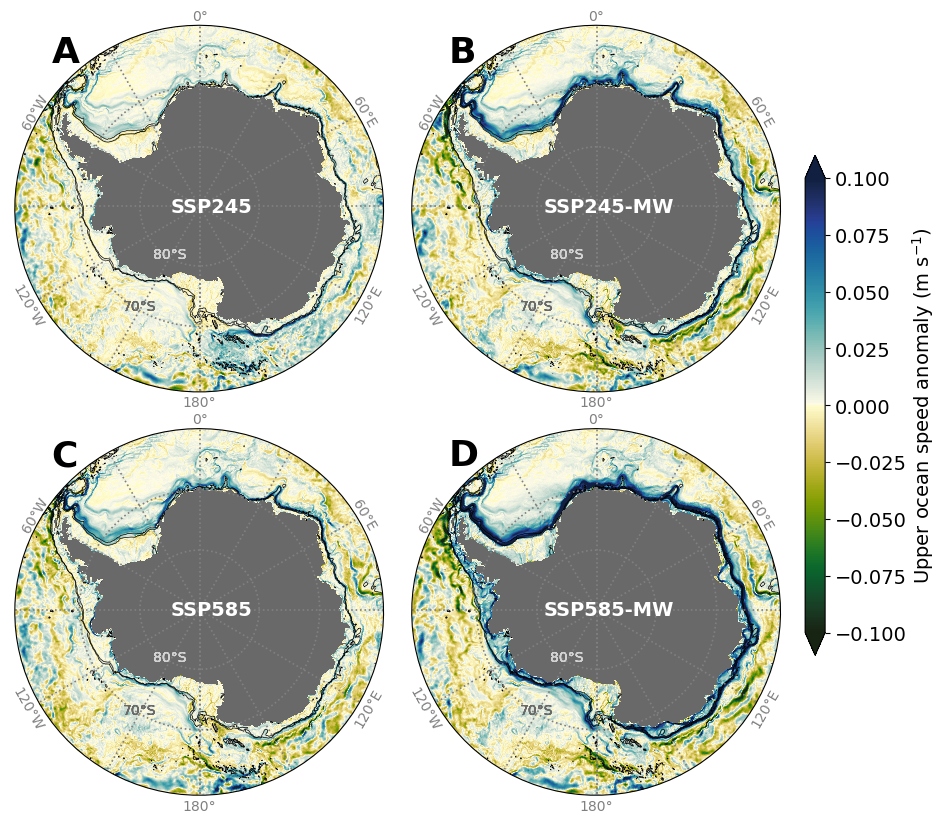

CPU times: user 3min 3s, sys: 36.2 s, total: 3min 39s
Wall time: 3min 3s


In [8]:
%%time
lat_slice  = slice(-80,-59)
scale_max = 20
fontsize=14
start_time, end_time = '2160-01-01', '2164-12-31'
labels = ['A','B','C','D']

fig,axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                subplot_kw={'projection': ccrs.SouthPolarStereo(), "aspect": 1},
                gridspec_kw = {'wspace':0.05, 'hspace':0.1},)
for i, ax in enumerate(axes.flatten()):
    add_circle_axes(fig, ax)
    ax.text(0.1, 0.9, f'{labels[i]}',  c='k', fontsize=26, fontweight='bold',transform=ax.transAxes)

    # Draw gridlines
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1.2, xlocs=range(-180, 181, 30), ylocs=[-80,-70,], 
                 color='grey', alpha=1, linestyle=':', rotate_labels=False, )
    
    # Plot text labels outside circular boundary
    for lon in range(-180,180,60):
        lat = -59 
        a1, a2 = -59.4, -60.4 
        if lon>=90 and lon<=170:
            plot_text([lon, a1+2.05], [lon, a2], ax, -lon-180, str(lon)+"°E")  #2.35
        elif lon<-90 and lon>=-170:
            plot_text([lon, a1+2.5], [lon, a2], ax, -lon+180, str(-lon)+"°W")  
        elif lon > 0:
            plot_text([lon, a1], [lon, a2], ax, -lon, str(lon)+"°E")
        elif lon==0:
            plot_text([lon, a1], [lon, a2], ax, lon, str(lon)+"°")
        elif lon==-180:
            plot_text([lon, a1+2.2], [lon, a2], ax, lon+180, str(-lon)+"°")
        else:
            plot_text([lon, a1], [lon, a2], ax, -lon, str(-lon)+"°W")
            pass
        
        # plot latitude labels
        ax.text(-150, -80, '80\u00b0S', ha='center', color='lightgrey', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(-150, -70, '70\u00b0S', ha='center', color='dimgrey', fontsize=10, transform=ccrs.PlateCarree())


expt_speed = [upper_spd_ssp245, upper_spd_ssp245mw, upper_spd_ssp585, upper_spd_ssp585mw]
expt_labels = ['SSP245','SSP245-MW','SSP585','SSP585-MW']
for i, expt in enumerate(expt_speed):
    print(i)
    #spd_expt = read_data(start_time, end_time, expt, expt_session)
    cb = plot_anom(axes.flatten()[i], expt, upper_spd_ctrl, f'{expt_labels[i]}', 0.1, cmo.delta_r)

#plot colorbars
colorbar_vert(cb, [0.92, 0.25, 0.02, 0.5], 'Upper ocean speed anomaly (m s$^{-1}$)')


# save to file
print("Saving figure")
figfile = f'/home/561/hd4873/project3/figs/SuppFigS16_0-500m_spd_anom_2160-2164.jpg'
fig.savefig(figfile, bbox_inches='tight', dpi=300)
plt.show()

### Bottom Speeds

In [9]:
def select_bottom(ds, depth_array, max_depth):
    bottom_ds = ds.where(depth_array.st_ocean >= max_depth)
    bottom_ds = bottom_ds.sum(dim = 'st_ocean')
    bottom_ds = bottom_ds.load()
    return bottom_ds

In [10]:
def read_bottom_data(start_time, end_time, expt, session):
    print(f"Reading velocities from: {expt}")
    lat_slice  = slice(-80,-59)
    uvel = cc.querying.getvar(expt,'u',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice)
    vvel = cc.querying.getvar(expt,'v',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice)

    # select bottom velocities
    print(f"Selecting bottom velocities")
    depth_array = uvel.isel(time=0) * 0 + uvel.st_ocean
    max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
    bottom_uvel = select_bottom(uvel, depth_array, max_depth)
    bottom_vvel = select_bottom(vvel, depth_array, max_depth)

    # calculate speed
    print(f"Calculating speed")
    spd = np.sqrt(bottom_uvel**2 + bottom_vvel**2)
    spd_ave = spd.groupby('time.month').mean(dim='time').load()
    
    return spd_ave

Read in control data. 

In [32]:
%%time
spd_ctrl = read_bottom_data('2160-01-01', '2164-12-31', control, master_session)

Reading velocities from: 01deg_jra55v13_ryf9091
Selecting bottom velocities


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/reductions.py:651: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Calculating speed
CPU times: user 12min 42s, sys: 1min 27s, total: 14min 10s
Wall time: 19min 19s


Read in experiment data. 

In [34]:
%%time
spd_ssp245 = read_bottom_data('2160-01-01', '2164-12-31', ssp245, expt_session)
spd_ssp245mw = read_bottom_data('2160-01-01', '2164-12-31', ssp245mw, expt_session)
spd_ssp585 = read_bottom_data('2160-01-01', '2164-12-31', ssp585, expt_session)
spd_ssp585mw = read_bottom_data('2160-01-01', '2164-12-31', ssp585mw, expt_session)

Reading velocities from: 01deg_jra55v13_ryf9091_ssp245
Selecting bottom velocities
Calculating speed
Reading velocities from: 01deg_jra55v13_ryf9091_ssp245_mw
Selecting bottom velocities
Calculating speed
Reading velocities from: 01deg_jra55v13_ryf9091_ssp585
Selecting bottom velocities
Calculating speed
Reading velocities from: 01deg_jra55v13_ryf9091_ssp585_mw
Selecting bottom velocities
Calculating speed
CPU times: user 1h 28min 22s, sys: 9min 6s, total: 1h 37min 29s
Wall time: 2h 8min 48s


Save to file. 

In [35]:
spd_ctrl = spd_ctrl.rename('speed')
spd_ctrl.attrs['Name'] = 'Bottom speed climatology'
spd_ctrl.attrs['Units'] = 'm/s'
spd_ctrl.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ctrl.attrs['Experiment'] = 'Control (RYF)'
spd_ctrl.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/bottom_speed_control.nc')

spd_ssp245 = spd_ssp245.rename('speed')
spd_ssp245.attrs['Name'] = 'Bottom speed climatology'
spd_ssp245.attrs['Units'] = 'm/s'
spd_ssp245.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp245.attrs['Experiment'] = 'SSP245'
spd_ssp245.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/bottom_speed_ssp245.nc')

spd_ssp245mw = spd_ssp245mw.rename('speed')
spd_ssp245mw.attrs['Name'] = 'Bottom speed climatology'
spd_ssp245mw.attrs['Units'] = 'm/s'
spd_ssp245mw.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp245mw.attrs['Experiment'] = 'SSP245 with Meltwater'
spd_ssp245mw.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/bottom_speed_ssp245mw.nc')

spd_ssp585 = spd_ssp585.rename('speed')
spd_ssp585.attrs['Name'] = 'Bottom speed climatology'
spd_ssp585.attrs['Units'] = 'm/s'
spd_ssp585.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp585.attrs['Experiment'] = 'SSP585'
spd_ssp585.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/bottom_speed_ssp585.nc')

spd_ssp585mw = spd_ssp585mw.rename('speed')
spd_ssp585mw.attrs['Name'] = 'Bottom speed climatology'
spd_ssp585mw.attrs['Units'] = 'm/s'
spd_ssp585mw.attrs['Period'] = '01-01-2160 to 31-12-2164'
spd_ssp585mw.attrs['Experiment'] = 'SSP585 with Meltwater'
spd_ssp585mw.to_netcdf('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/bottom_speed_ssp585mw.nc')

In [52]:
spd_ctrl = spd_ctrl.sel(yu_ocean=slice(None, -59))
spd_ssp245 = spd_ssp245.sel(yu_ocean=slice(None, -59))
spd_ssp245mw = spd_ssp245mw.sel(yu_ocean=slice(None, -59))
spd_ssp585 = spd_ssp585.sel(yu_ocean=slice(None, -59))
spd_ssp585mw = spd_ssp585mw.sel(yu_ocean=slice(None, -59))

Read data back in 

In [11]:
dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/'
lat_slice = slice(-80,-59)

bottom_spd_ctrl = xr.open_dataset(dir+'bottom_speed_control.nc').sel(yu_ocean=lat_slice)['speed'].mean('month')
bottom_spd_ssp245 = xr.open_dataset(dir+'bottom_speed_ssp245.nc').sel(yu_ocean=lat_slice)['speed'].mean('month')
bottom_spd_ssp245mw = xr.open_dataset(dir+'bottom_speed_ssp245mw.nc').sel(yu_ocean=lat_slice)['speed'].mean('month')
bottom_spd_ssp585 = xr.open_dataset(dir+'bottom_speed_ssp585.nc').sel(yu_ocean=lat_slice)['speed'].mean('month')
bottom_spd_ssp585mw = xr.open_dataset(dir+'bottom_speed_ssp585mw.nc').sel(yu_ocean=lat_slice)['speed'].mean('month')

Now plot anomalies. 

0
1
2
3
Saving figure


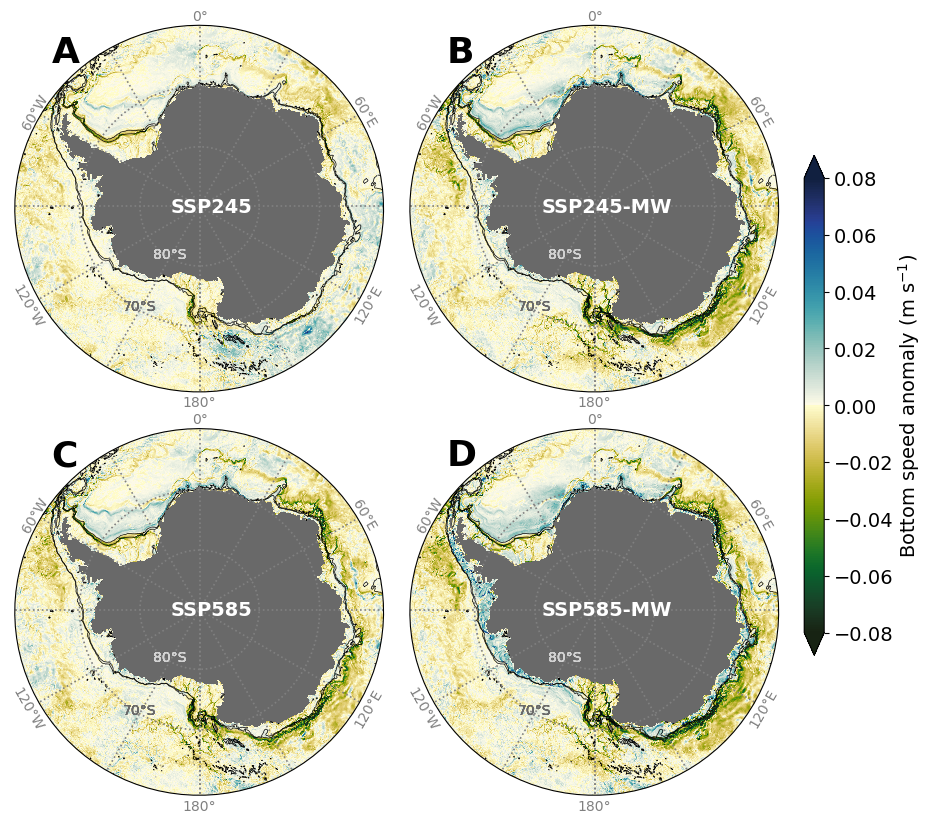

CPU times: user 3min 4s, sys: 37.5 s, total: 3min 42s
Wall time: 3min 4s


In [12]:
%%time
lat_slice  = slice(-80,-59)
scale_max = 20
fontsize=14
start_time, end_time = '2160-01-01', '2164-12-31'
labels = ['A','B','C','D']

fig,axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                subplot_kw={'projection': ccrs.SouthPolarStereo(), "aspect": 1},
                gridspec_kw = {'wspace':0.04, 'hspace':0.1},)
for i, ax in enumerate(axes.flatten()):
    add_circle_axes(fig, ax)
    ax.text(0.1, 0.9, f'{labels[i]}',  c='k', fontsize=26, fontweight='bold',transform=ax.transAxes)
    # Draw gridlines
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1.2, xlocs=range(-180, 181, 30), ylocs=[-80,-70,], 
                 color='grey', alpha=1, linestyle=':', rotate_labels=False, )
    
    # Plot text labels outside circular boundary
    for lon in range(-180,180,60):
        lat = -59  
        a1, a2 = -59.4, -60.4  
        if lon>=90 and lon<=170:
            plot_text([lon, a1+2.05], [lon, a2], ax, -lon-180, str(lon)+"°E")  
        elif lon<-90 and lon>=-170:
            plot_text([lon, a1+2.5], [lon, a2], ax, -lon+180, str(-lon)+"°W")  
        elif lon > 0:
            plot_text([lon, a1], [lon, a2], ax, -lon, str(lon)+"°E")
        elif lon==0:
            plot_text([lon, a1], [lon, a2], ax, lon, str(lon)+"°")
        elif lon==-180:
            plot_text([lon, a1+2.2], [lon, a2], ax, lon+180, str(-lon)+"°")
        else:
            plot_text([lon, a1], [lon, a2], ax, -lon, str(-lon)+"°W")
            pass
        
        # plot latitude labels
        ax.text(-150, -80, '80\u00b0S', ha='center', color='lightgrey', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(-150, -70, '70\u00b0S', ha='center', color='dimgrey', fontsize=10, transform=ccrs.PlateCarree())



expt_speed = [bottom_spd_ssp245, bottom_spd_ssp245mw, bottom_spd_ssp585, bottom_spd_ssp585mw]
expt_labels = ['SSP245','SSP245-MW','SSP585','SSP585-MW']
for i, expt in enumerate(expt_speed):
    print(i)
    cb = plot_anom(axes.flatten()[i], expt, bottom_spd_ctrl, f'{expt_labels[i]}', 0.08, cmo.delta_r)
#plot colorbar
colorbar_vert(cb, [0.92, 0.25, 0.02, 0.5], 'Bottom speed anomaly (m s$^{-1}$)')

# # save to file
print("Saving figure")
figfile = f'/home/561/hd4873/project3/figs/SuppFigS17_bottom_spd_anom_2160-2164.jpg'
fig.savefig(figfile, bbox_inches='tight', dpi=300)
plt.show()